In [18]:
#roadmap / methodology

#ttests / 1way anova

#modelling
###OLS regression
###RF
######validation plots
######feature importance

###Ridge regression
###Lasso regression

#model comparison

#model export/import

In [2]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
from statsmodels.stats.multitest import multipletests

#rf libs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#feature importance libs
#import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

#ridge / lasso model libs
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#import numpy as np
from sklearn.compose import TransformedTargetRegressor
import sklearn

#load
df = pd.read_csv("data_clean/obesity_behavior.csv")
df.head()


,locationabbr,income,sex,ageyears,race_ethnicity,education,obesity_pct,q_Q018,q_Q019,q_Q043,q_Q044,q_Q045,q_Q046,q_Q047
0,AK,15000 - 24999,NaN,NaN,NaN,NaN,31.941637,44.459184,25.423956,51.691377,22.038088,36.016070,35.194268,28.208200
1,AK,25000 - 34999,NaN,NaN,NaN,NaN,32.286771,41.806591,26.649741,55.223399,26.086586,36.605200,36.114340,24.283622
2,AK,35000 - 49999,NaN,NaN,NaN,NaN,32.713885,41.492265,20.151036,58.203993,25.678555,37.234582,36.138584,22.557282
3,AK,50000 - 74999,NaN,NaN,NaN,NaN,31.984576,37.645757,15.409079,58.379217,26.928504,39.159051,38.692741,18.559281
4,AK,75000 or greater,NaN,NaN,NaN,NaN,30.043756,37.025210,11.934425,64.038179,28.985706,41.741825,38.056197,15.082539


In [3]:
#validate
#df.describe(include="all")


In [4]:
#test ttest to validate function
male = df[df["sex"]=="Male"]["obesity_pct"]
female = df[df["sex"]=="Female"]["obesity_pct"]

# Independent t-test
t_stat, p_val = stats.ttest_ind(male, female, nan_policy="omit")
print("t-test obesity by sex: t=%.3f, p=%.3f" % (t_stat, p_val))


t-test obesity by sex: t=-0.196, p=0.845


In [5]:
#functional ttest adn anova for all pairwise calcs

def run_group_tests(df, cat, target="obesity_pct"):
    d = df[[cat, target]].dropna()
    groups = {k: v[target].values for k, v in d.groupby(cat)}
    levels = [k for k in groups if pd.notna(k)]
    print(f"\n=== {cat.upper()} ===")
    print("Levels:", levels)

    if len(levels) == 2:
        a, b = levels
        t, p = stats.ttest_ind(groups[a], groups[b], equal_var=False, nan_policy="omit")
        print(f"Welch t-test: {a} vs {b}  t={t:.3f}, p={p:.4g}")
        print(f"Means: {a}={np.nanmean(groups[a]):.2f}, {b}={np.nanmean(groups[b]):.2f}")
    elif len(levels) > 2:
        #one way ANOVA
        f, p = stats.f_oneway(*[groups[k] for k in levels])
        print(f"One-way ANOVA: F={f:.3f}, p={p:.4g}")

        #pairwise welch ttest with holm adj
        pairs, pvals = [], []
        for a, b in combinations(levels, 2):
            t, p = stats.ttest_ind(groups[a], groups[b], equal_var=False, nan_policy="omit")
            pairs.append((a, b)); pvals.append(p)
        rej, p_adj, _, _ = multipletests(pvals, method="holm")
        out = pd.DataFrame({
            "pair": [f"{a} vs {b}" for a,b in pairs],
            "p_raw": pvals,
            "p_holm": p_adj,
            "significant": rej
        }).sort_values("p_holm")
        display(out.head(len(out)))
    else:
        print("Not enough levels to test.")

#strata run
for col in ["sex", "race_ethnicity", "income", "education"]:
    run_group_tests(df, col)



=== SEX ===
Levels: ['Female', 'Male']
Welch t-test: Female vs Male  t=0.196, p=0.8447
Means: Female=30.70, Male=30.56

=== RACE_ETHNICITY ===
Levels: ['American Indian/Alaska Native', 'Asian', 'Hawaiian/Pacific Islander', 'Hispanic', 'Non-Hispanic Black', 'Non-Hispanic White', 'Other']
One-way ANOVA: F=147.817, p=1.203e-86


,pair,p_raw,p_holm,significant
7,Asian vs Hispanic,2.425283e-53,5.093095e-52,True
10,Asian vs Other,5.140334e-48,1.028067e-46,True
8,Asian vs Non-Hispanic Black,8.066767e-45,1.532686e-43,True
9,Asian vs Non-Hispanic White,1.568681e-38,2.823625e-37,True
0,American Indian/Alaska Native vs Asian,6.010070e-36,1.021712e-34,True
18,Non-Hispanic Black vs Non-Hispanic White,7.534981e-15,1.205597e-13,True
4,American Indian/Alaska Native vs Non-Hispanic ...,3.267393e-10,4.901090e-09,True
19,Non-Hispanic Black vs Other,1.051743e-08,1.472440e-07,True
16,Hispanic vs Non-Hispanic White,2.034691e-07,2.645099e-06,True
15,Hispanic vs Non-Hispanic Black,3.247562e-07,3.897074e-06,True



=== INCOME ===
Levels: ['15000 - 24999', '25000 - 34999', '35000 - 49999', '50000 - 74999', '75000 or greater', 'Less than 15000']
One-way ANOVA: F=24.829, p=3.536e-21


,pair,p_raw,p_holm,significant
14,75000 or greater vs Less than 15000,2.413110e-16,3.619665e-15,True
3,15000 - 24999 vs 75000 or greater,6.077679e-12,8.508751e-11,True
7,25000 - 34999 vs 75000 or greater,2.013156e-09,2.617103e-08,True
10,35000 - 49999 vs 75000 or greater,2.574358e-08,3.089230e-07,True
12,50000 - 74999 vs 75000 or greater,7.249389e-07,7.974328e-06,True
13,50000 - 74999 vs Less than 15000,7.025885e-06,7.025885e-05,True
11,35000 - 49999 vs Less than 15000,8.775890e-05,7.898301e-04,True
8,25000 - 34999 vs Less than 15000,2.457159e-04,1.965727e-03,True
2,15000 - 24999 vs 50000 - 74999,1.055288e-02,7.387016e-02,False
4,15000 - 24999 vs Less than 15000,3.680663e-02,2.208398e-01,False



=== EDUCATION ===
Levels: ['<High school', 'College', 'High school', 'Some college/tech']
One-way ANOVA: F=74.639, p=3.655e-33


,pair,p_raw,p_holm,significant
0,<High school vs College,4.370460e-22,2.622276e-21,True
3,College vs High school,8.560433e-18,4.280217e-17,True
4,College vs Some college/tech,6.351609e-16,2.540644e-15,True
2,<High school vs Some college/tech,4.423586e-03,1.327076e-02,True
1,<High school vs High school,1.814394e-02,3.628789e-02,True
5,High school vs Some college/tech,5.206684e-01,5.206684e-01,False


In [6]:
#error troubleshooting

#print(d.dtypes)
#print(d.isna().sum())

#should be empty
#print(X.dtypes[X.dtypes == 'object']) 
#should be True
#print(X.shape, np.isfinite(X.values).all())


In [19]:
#OLS regression

q_cols = ["q_Q018","q_Q019","q_Q043","q_Q044","q_Q045","q_Q046","q_Q047"]
cat_cols = ["sex","race_ethnicity","education","income","ageyears"]
num_cols = ["obesity_pct"] + q_cols
use_cols = num_cols + cat_cols

d = df[use_cols].copy()

#coerce nums, keeps breaking
for c in num_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

#dummies
for c in cat_cols:
    d[c] = d[c].astype("category")
X = pd.get_dummies(d[cat_cols + q_cols], drop_first=True)
y = d["obesity_pct"].astype(float).values

#inf to NaN
X = X.replace([np.inf, -np.inf], np.nan)
bad_x = ~np.isfinite(X).all(axis=1)
bad_y = ~np.isfinite(y)
bad = bad_x | bad_y

#diag
#print("Initial:", X.shape[0], "rows")
#print("Rows with bad X:", int(bad_x.sum()), " | bad y:", int(bad_y.sum()), " | union:", int(bad.sum()))

X_clean = X.loc[~bad].astype(float)
y_clean = y[~bad]

#diag
#print("After cleaning:", X_clean.shape, "| y:", y_clean.shape)

#add const and fit
X_const = sm.add_constant(X_clean, has_constant="add")
model = sm.OLS(y_clean, X_const).fit(cov_type="HC3")

#finallyworking!
print(model.summary2())


                              Results: Ordinary least squares
Model:                        OLS                      Adj. R-squared:             0.743    
Dependent Variable:           y                        AIC:                        6958.7198
Date:                         2025-09-21 00:56         BIC:                        7104.2060
No. Observations:             1334                     Log-Likelihood:             -3451.4  
Df Model:                     27                       F-statistic:                183.9    
Df Residuals:                 1306                     Prob (F-statistic):         0.00     
R-squared:                    0.748                    Scale:                      10.568   
--------------------------------------------------------------------------------------------
                                          Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------------------------
const   

In [8]:
##RF regressor training and eval

q_cols   = ["q_Q018","q_Q019","q_Q043","q_Q044","q_Q045","q_Q046","q_Q047"]
cat_cols = ["sex","race_ethnicity","education","income","ageyears"]
target   = "obesity_pct"

#select and coerce
d = df[[target] + q_cols + cat_cols].copy()
for c in [target] + q_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")
for c in cat_cols:
    d[c] = d[c].astype("category")

#dummies
X = pd.get_dummies(d[q_cols + cat_cols], drop_first=True)
y = d[target].astype(float)

#NaN drop
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]

#train / test / split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#rf regressor
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

#predictions and metrics
pred = rf.predict(X_test)
r2   = r2_score(y_test, pred)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(f"RandomForestRegressor | R²: {r2:.3f}  MAE: {mae:.3f}  RMSE: {rmse:.3f}")

#suggested cross validation (5-fold R²)
cv_r2 = cross_val_score(rf, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)
print(f"CV R² (mean ± sd): {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

X_train.shape, X_test.shape


RandomForestRegressor | R²: 0.779  MAE: 2.297  RMSE: 3.216
CV R² (mean ± sd): 0.736 ± 0.043


((933, 27), (401, 27))

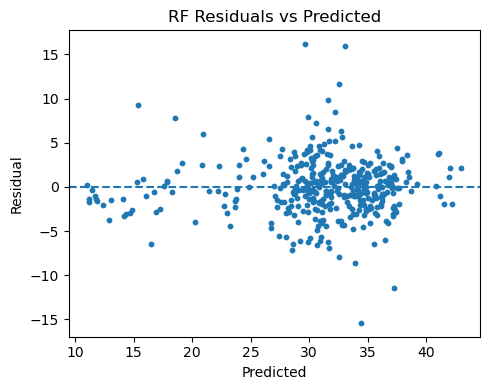

In [9]:
#residual validation plot for bias, random around zero is good, no curves or lines
resid = y_test - pred
plt.figure(figsize=(5,4)); plt.scatter(pred, resid, s=10); plt.axhline(0, ls="--")
plt.title("RF Residuals vs Predicted"); plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

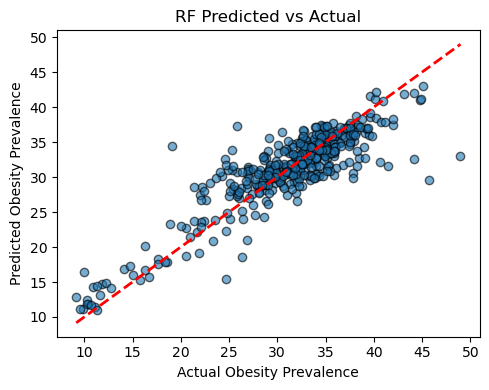

In [10]:
#additional predicted v actual validation plot
plt.figure(figsize=(5,4))
plt.scatter(y_test, pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2)

plt.xlabel("Actual Obesity Prevalence")
plt.ylabel("Predicted Obesity Prevalence")
plt.title("RF Predicted vs Actual")
plt.tight_layout()
plt.show()

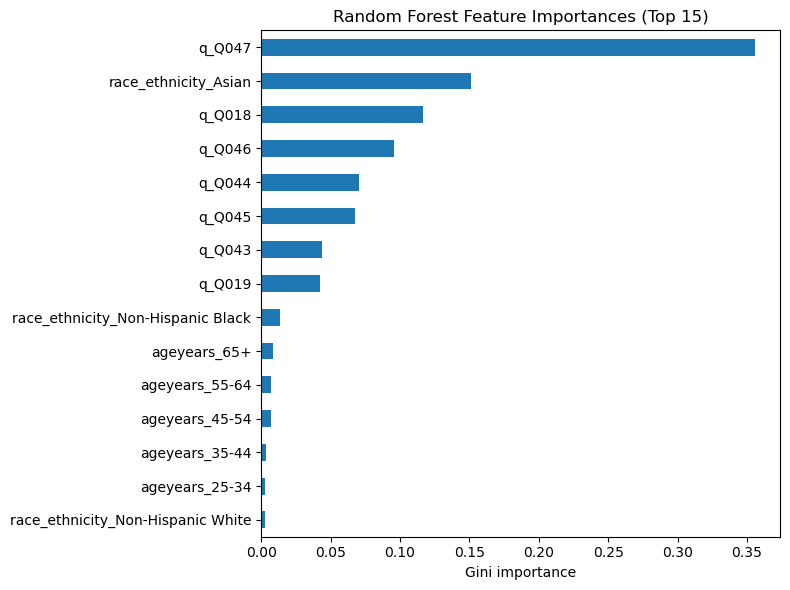

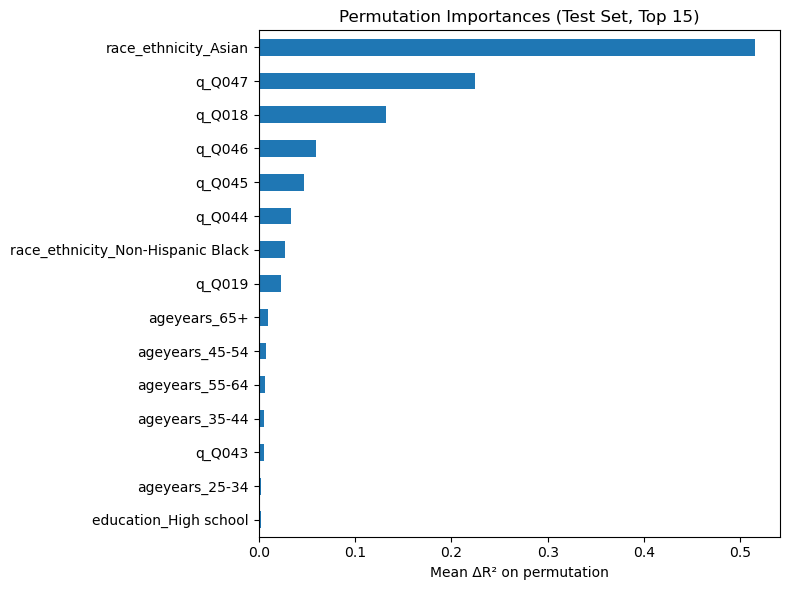

,feature,gini_importance,perm_importance
1,race_ethnicity_Asian,0.150817,0.515255
0,q_Q047,0.355910,0.224391
2,q_Q018,0.116178,0.131663
3,q_Q046,0.095907,0.059448
5,q_Q045,0.067424,0.047021
4,q_Q044,0.070155,0.033936
8,race_ethnicity_Non-Hispanic Black,0.013596,0.026911
7,q_Q019,0.042695,0.022782
9,ageyears_65+,0.008733,0.010066
11,ageyears_45-54,0.007075,0.007944


In [11]:
#gini based feature importances
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
topn = 15
ax = imp.head(topn).sort_values().plot(kind="barh", figsize=(8,6))
ax.set_title(f"Random Forest Feature Importances (Top {topn})")
ax.set_xlabel("Gini importance")
plt.tight_layout()
plt.show()

#permutation importances
perm = permutation_importance(rf, X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
ax = perm_imp.head(topn).sort_values().plot(kind="barh", figsize=(8,6))
ax.set_title(f"Permutation Importances (Test Set, Top {topn})")
ax.set_xlabel("Mean ΔR² on permutation")
plt.tight_layout()
plt.show()

#table
feat_summary = pd.DataFrame({
    "feature": imp.index,
    "gini_importance": imp.values,
    "perm_importance": perm_imp.reindex(imp.index).values
}).sort_values("perm_importance", ascending=False)
feat_summary.head(20)


In [12]:
#basic ridge regression and lasso regression model constructor

def eval_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2 = r2_score(y_test, pred); mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} | R²: {r2:.3f}  MAE: {mae:.3f}  RMSE: {rmse:.3f}")
    return model

ridge = make_pipeline(StandardScaler(with_mean=False), RidgeCV(alphas=np.logspace(-3,3,25), cv=5))
lasso = make_pipeline(StandardScaler(with_mean=False), LassoCV(alphas=np.logspace(-3,3,25), cv=5, max_iter=10000))

ridge_m = eval_model("Ridge", ridge, X_train, X_test, y_train, y_test)
lasso_m = eval_model("Lasso", lasso, X_train, X_test, y_train, y_test)


Ridge | R²: 0.761  MAE: 2.509  RMSE: 3.346
Lasso | R²: 0.761  MAE: 2.514  RMSE: 3.348


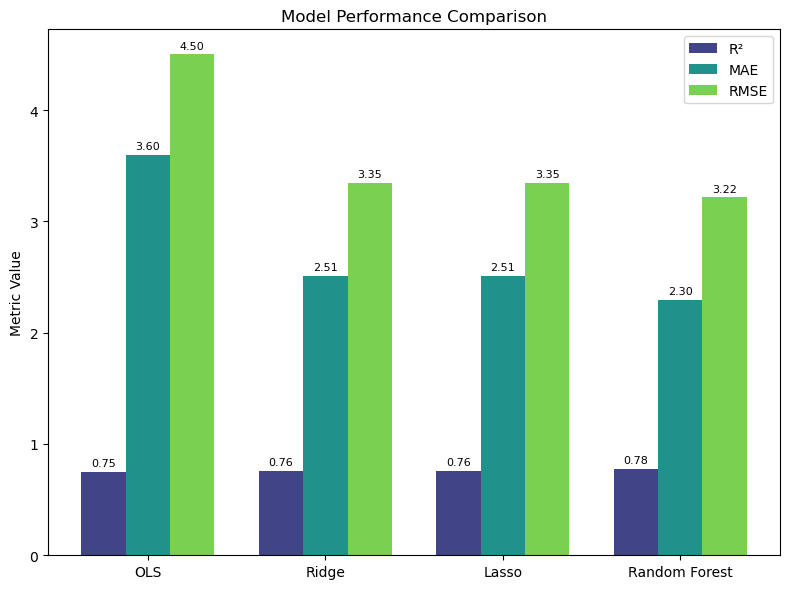

In [17]:

import matplotlib.cm as cm


#manual metrics
models = ["OLS", "Ridge", "Lasso", "Random Forest"]
r2   = [0.748, 0.761, 0.761, 0.779]
mae  = [3.6, 2.509, 2.512, 2.297]
rmse = [4.5, 3.346, 3.347, 3.216]

#rf: R²: 0.779  MAE: 2.297  RMSE: 3.216



#viridis
colors = cm.viridis(np.linspace(0.2, 0.8, 3))

#plot
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x - width, r2, width, label="R²", color=colors[0])
ax.bar(x, mae, width, label="MAE", color=colors[1])
ax.bar(x + width, rmse, width, label="RMSE", color=colors[2])

ax.set_ylabel("Metric Value")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

#values
for metric_vals, offset in zip([r2, mae, rmse], [-width, 0, width]):
    for i, v in enumerate(metric_vals):
        ax.text(i + offset, v + 0.05, f"{v:.2f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


In [14]:
#export model and test set w target

import joblib, os
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_obesity.joblib")
X_test.assign(obesity_pct=y_test).to_csv("data_clean/test_set_with_target.csv", index=False)


In [ ]:
#model reload for future use

#import joblib
#import pandas as pd

#load model
rf_loaded = joblib.load("models/rf_obesity.joblib")

#load prev export for col comparison
test_df = pd.read_csv("data_clean/test_set_with_target.csv")
expected_features = test_df.drop(columns=["obesity_pct"]).columns

#features only, no target col
new_data = pd.read_csv("data_clean/new_data.csv")

#check for col mismatch
missing = set(expected_features) - set(new_data.columns)
extra   = set(new_data.columns) - set(expected_features)

if missing:
    print("Missing columns in new data:", missing)
if extra:
    print("Extra columns in new data (ignored if not needed):", extra)

#reorder if misaligned
new_data = new_data[expected_features]

#generate predictions
predictions = rf_loaded.predict(new_data)

#outputs
output = new_data.copy()
output["predicted_obesity_pct"] = predictions
output.to_csv("data_clean/new_data_with_predictions.csv", index=False)
print("..saved to data_clean/new_data_with_predictions.csv")
